# Analysis Notebook

In [121]:
import pandas as pd
import os
import operator

#os.chdir("/Users/bencampbell/code_louisville/capstone/louisville-bike-accidents/")

DATAPATH = "data/clean/bike_accidents.csv"
assert os.path.exists(DATAPATH)

DATA = DATA = pd.read_csv(DATAPATH)


In [135]:
# Adding some useful columns and defining some functions for use later in this notebook.

# New Columns
# Boolean value: True -> Casualty (injury or fatality); False -> Noncasualty
DATA['casualty_indicator'] = DATA['fatality_indicator'] | DATA['injury_indicator']
DATA['noncasualty_indicator'] = ~(DATA['fatality_indicator'] | DATA['injury_indicator'])

# Some roadways have a number but no name. Combine these values into a single column. 
# roadway name if any else roadway number. 
DATA['main_roadway'] = DATA['roadway_name'].combine_first(DATA['roadway_number'])
DATA['intersection_roadway'] = DATA['intersection_roadway_name'].combine_first(DATA['intersection_roadway_number'])

# Boolean value: True -> accident occurred in an intersection / between streets
DATA['intersection_indicator'] = DATA['intersection_roadway'].notnull()
DATA['between_street_indicator'] = (
    DATA['between_street_name_1'].notnull() | DATA['between_street_name_2'].notnull() | 
    DATA['between_street_number_1'].notnull() | DATA['between_street_number_2'].notnull())


DATA.columns

Index(['investigating_agency', 'roadway_number', 'building_number',
       'roadway_name', 'roadway_suffix', 'roadway_direction', 'milepoint',
       'intersection_roadway_number', 'intersection_roadway_name',
       'between_street_number_1', 'between_street_name_1',
       'between_street_number_2', 'between_street_name_2', 'units_involved',
       'motor_vehicles_involved', 'weather', 'roadway_condition',
       'hit_and_run_indicator', 'roadway_type', 'directional_analysis',
       'manner_of_collision', 'roadway_character', 'light_condition',
       'secondary_collision_indicator', 'date', 'latitude', 'longitude',
       'injury_indicator', 'fatality_indicator', 'day_of_week', 'id', 'year',
       'month', 'day', 'hour', 'minute', 'casualty_indicator',
       'noncasualty_indicator', 'main_roadway', 'intersection_roadway',
       'intersection_indicator', 'between_street_indicator'],
      dtype='object')

In [156]:


# Useful function definitions / constants
TOTAL_ACCIDENTS = len(DATA) # Total number of accident reports
DANGERMASK = ['fatality_indicator', 'injury_indicator', 'casualty_indicator', 'noncasualty_indicator' ]
# This will get used over and over to analyse relative frequencies of crash outcomes.

def percent_round(x):
    """Create a readable percentage float using round()"""
    return round(x*100, 2)

def percent_format(x):
    """Format a number as a percentage."""
    return format(x, ".2%")


class DangerReport(pd.DataFrame):
    @property
    def totals(df):
        return df['casualties'] + df['noncasualties']
    
    def get_ratio_by_total(df):
        return (df/TOTAL_ACCIDENTS).apply(percent_round)

    def get_ratio_by_value_total(df):
        #totals = df['casualties'] + df['noncasualties']
        return df.apply(lambda x:x/df.totals).apply(percent_round)


def get_danger_report(df, label):
    report = df.groupby(label)[DANGERMASK].sum()
    report = report.rename({"injury_indicator":'injuries', 
                          'fatality_indicator':'fatalities',
                          'casualty_indicator':'casualties',
                          'noncasualty_indicator':'noncasualties'}, axis=1)
    #report['total'] = report['casualties'] + report['noncasualties']
    return DangerReport(report)


<Axes: xlabel='hour of day', ylabel='accident count'>

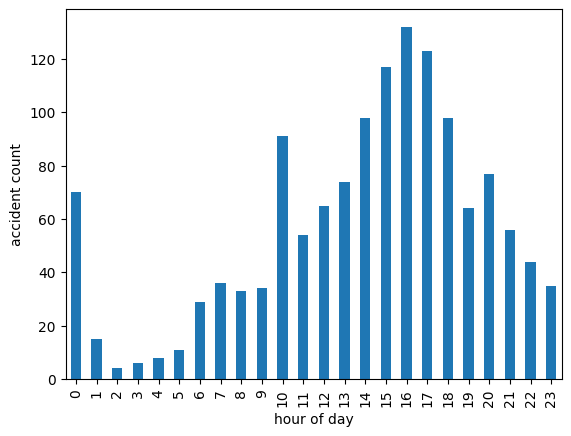

In [107]:
# Time of Day
# show sampling issue with dataset
DATA.groupby('hour').size().plot(kind='bar', xlabel='hour of day', ylabel="accident count")

<Axes: xlabel='hour of day', ylabel='count of light_condition == DAYLIGHT'>

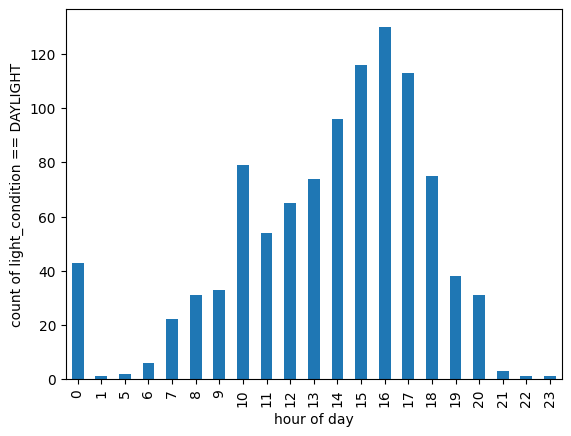

In [108]:
hour_light = DATA[['hour', 'light_condition']]
hour_light[hour_light['light_condition'] == "DAYLIGHT"].groupby('hour').size().plot(
    kind='bar', xlabel='hour of day', ylabel='count of light_condition == DAYLIGHT')

In [115]:
zeros = DATA[(DATA.hour==0) & (DATA.minute==0)]
# Get all rows that have 00:00 time value


#zeros[zeros['date'].apply(lambda x:x.second==0)]
# Check that the seconds are zero too.

zeros_index = zeros[zeros['light_condition'] == "DAYLIGHT"].index
# For recrods that have 00:00 time, find the ones that have light_condition == DAYLIGHT, 
# then filter these records out of my data:
zeros_index

Index([  31,   87,   95,   98,  101,  104,  109,  138,  171,  178,  189,  211,
        234,  334,  341,  349,  396,  479,  574,  578,  600,  602,  615,  670,
        709,  710,  711,  743,  786,  867,  882,  962,  979,  981,  997, 1045,
       1106, 1114, 1155, 1165, 1177, 1218],
      dtype='int64')

<Axes: xlabel='hour of day', ylabel='DAYLIGHT'>

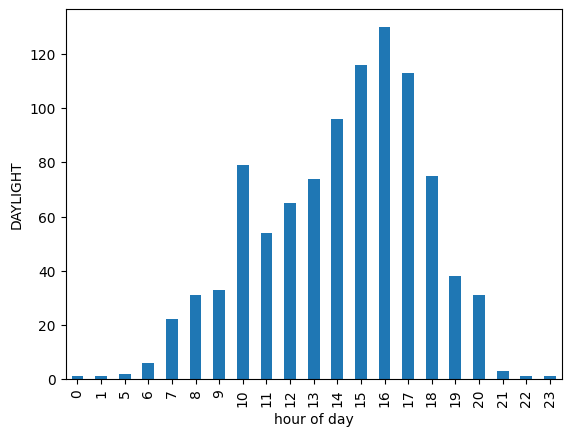

In [147]:
filtered_light = DATA[~DATA.index.isin(zeros_index)]
# Now let's see what the time distribution for DAYLIGHT condition looks like:
filtered_light[filtered_light['light_condition'] == "DAYLIGHT"].groupby('hour').size().plot(
    kind='bar', ylabel='DAYLIGHT', xlabel='hour of day')

In [160]:
#r = DangerReport(filtered_light.groupby('light_condition')[DANGERMASK].sum())
r =get_danger_report(filtered_light, 'light_condition')
r.get_ratio_by_value_total()

,fatalities,injuries,casualties,noncasualties
light_condition,,,,
DARK (UNKNOWN ROADWAY LIGHTING),0.00,85.71,85.71,14.29
DARK-HWY LIGHTED/OFF,7.69,80.77,88.46,11.54
DARK-HWY LIGHTED/ON,0.57,72.00,72.57,27.43
DARK-HWY NOT LIGHTED,25.81,67.74,93.55,6.45
DAWN,0.00,74.19,74.19,25.81
DAYLIGHT,1.34,69.14,70.37,29.63
DUSK,1.72,67.24,68.97,31.03
OTHER,100.00,0.00,100.00,0.00


In [146]:

r.loc['WET'] = get_danger_report('roadway_condition').iloc[1:].sum()
r = r.loc[['DRY', 'WET']]
r.get_ratio_by_total()

,fatalities,injuries,casualties,noncasualties
roadway_condition,,,,
DRY,2.11,63.76,65.79,25.98
WET,0.36,6.04,6.40,1.82


In [161]:
# Most dangerous roads?

#top_most_dangerous_roads = 
# Group by road type?
# Find percents by this: what percent of accidents occur in these most dangerous roads.
#top_most_dangerous_roads.plot(kind='bar', ylabel='value count')



Unfortunately, there is still a major issue with the data: we do not know how many people are cycling at different times of day. Cyclists tend to avoid riding at night. So, while there are low numbers of accidents at 3 AM, that may only reflect the relatively low number of cyclists riding at that hour, and not the actual danger of that hour to ride as a ratio of riders to accident reports. 

Similarly, we see a very high number of accidents at 3 PM. It may not be the case that 3 PM is an exceptionally dangerous time to ride. There are many cyclists on the road at this time, therefore there are more opportunities for accidents vs. the small number of cyclists who ride at night. 

From these graphs, it's pretty clear to see that cycling in the dark is much less safe than cycling in the day, even though more accidents occur in the day. 



## Road conditions

In [ ]:
out = DATA.groupby(['roadway_condition', 'weather', 'light_condition'])[['injury_indicator', 'fatality_indicator']].sum()
#
#df['roadway_condition'].replace(to_replace='WATER (STANDING OR MOVING)',value='WATER', inplace=True)
condition_codes = pd.DataFrame(DATA['roadway_condition'].unique())
condition_codes['total'] = condition_codes[0].apply(lambda n:out.loc[n].sum().sum())

out.groupby(by='roadway_condition').sum()

,injury_indicator,fatality_indicator
roadway_condition,,
DRY,876,29
ICE,1,0
SNOW/SLUSH,3,0
WATER (STANDING OR MOVING),0,0
WET,79,5


In [ ]:
units = pd.DataFrame(DATA[['units_involved', 'motor_vehicles_involved']])
units['nonmotorized_units_involved'] = units['units_involved'] - units['motor_vehicles_involved']

units


,units_involved,motor_vehicles_involved,nonmotorized_units_involved
0,2,1,1
1,2,1,1
2,2,1,1
3,2,1,1
4,2,1,1
...,...,...,...
1369,3,2,1
1370,2,1,1
1371,2,1,1
1372,2,1,1


<Axes: xlabel='year'>

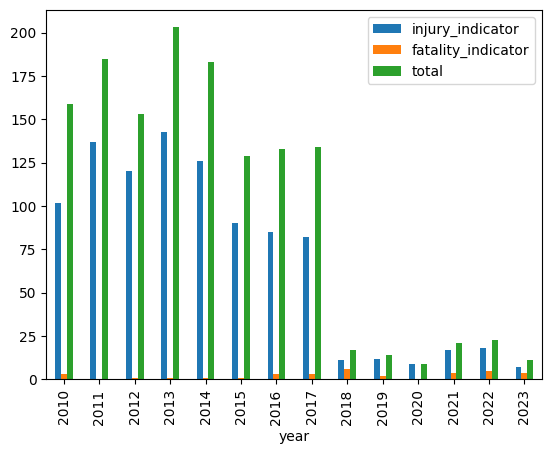

In [ ]:
# YEAR
years = DATA.groupby('year')[['injury_indicator', 'fatality_indicator']].sum()
years['total'] = DATA.groupby('year')['year'].size()

years.plot.bar()


<Axes: xlabel='month'>

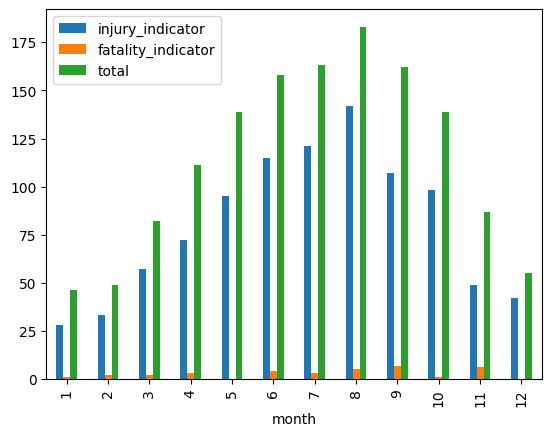

In [ ]:

# month
months = DATA.groupby('month')[['injury_indicator', 'fatality_indicator']].sum()
months['total'] = DATA.groupby('month')['month'].size()

months.plot.bar()

<Axes: xlabel='month'>

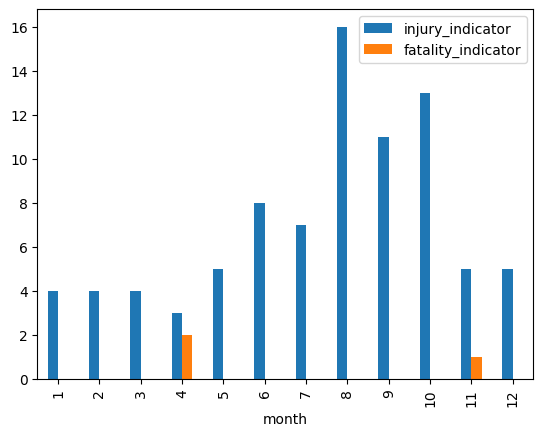

In [ ]:
#month_year
MY = DATA.groupby(['year', 'month'])[['injury_indicator', 'fatality_indicator']].sum()
#MY.groupby('month').sum().plot.bar()
MY.loc[2016].plot.bar()

manner_of_collision
SINGLE VEHICLE                  1273
ANGLE                             67
SIDESWIPE-SAME DIRECTION          14
REAR END                          10
HEAD ON                            6
OPPOSING LEFT TURN                 3
SIDESWIPE-OPPOSITE DIRECTION       1
Name: count, dtype: int64

<Axes: xlabel='manner_of_collision'>

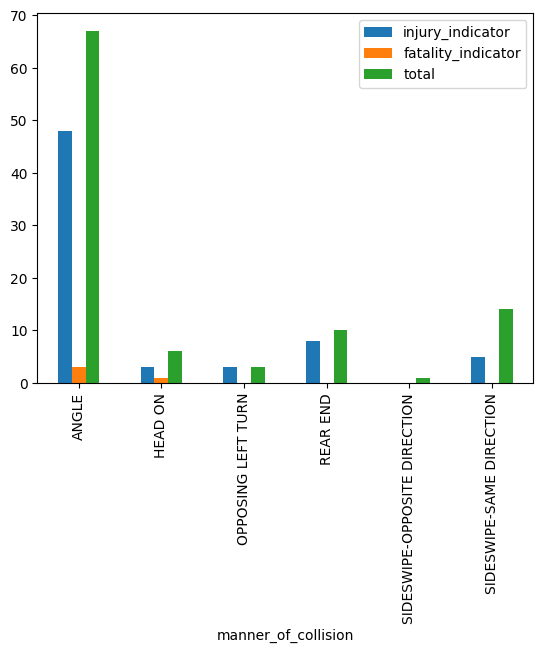

In [ ]:
def get_totals_by(by):
    out = DATA.groupby(by)[['injury_indicator', 'fatality_indicator']].sum()
    out['total'] = DATA.groupby(by)[by].size()

    #out.plot.bar()
    return out
#print(df.columns)

MOC = DATA['manner_of_collision']
display(MOC.value_counts())


# Plot not SINGLE VEHICLE
get_totals_by("manner_of_collision").iloc[:-1].plot.bar()

In [ ]:
geo = DATA[DATA['roadway_name'] == "DIXIE"][['longitude', 'latitude']]

import numpy as np
from math import sqrt


def point(longitude, latitude):
    return np.array((longitude, latitude))

def distance(point_a, point_b):
    long_a, lat_a = point_a
    long_b, lat_b = point_b
    dist_long = long_a - long_b
    dist_lat = lat_a - lat_b
    return sqrt(dist_long**2 + dist_lat**2)

points = pd.DataFrame(geo.longitude.combine(geo.latitude, point))

points


,0
37,"[-85.8047443, 38.1970461]"
56,"[-85.7915663, 38.2259046]"
86,"[-85.8040117, 38.1977195]"
125,"[-85.8266313, 38.1709652]"
135,"[-85.8067399, 38.1941699]"
...,...
1315,"[-85.79113155, 38.22668024]"
1325,"[-85.8399874, 38.14291255]"
1326,"[-85.8399874, 38.14291255]"
1347,"[-85.87415593, 38.09328054]"


In [ ]:

for index in points.index:
    comp = points[0][index]
    points[index] = points[0].apply(lambda x:distance(comp, x))

threshold = .05
out = list()
for i in points.index:
    for j in points.index:
        if points[j][i] <= threshold:
            out.append((i,j))
out, len(out)



([(37, 37),
  (37, 56),
  (37, 86),
  (37, 125),
  (37, 135),
  (37, 190),
  (37, 208),
  (37, 285),
  (37, 363),
  (37, 365),
  (37, 367),
  (37, 392),
  (37, 434),
  (37, 441),
  (37, 510),
  (37, 580),
  (37, 600),
  (37, 639),
  (37, 746),
  (37, 805),
  (37, 814),
  (37, 822),
  (37, 832),
  (37, 836),
  (37, 840),
  (37, 916),
  (37, 976),
  (37, 1042),
  (37, 1048),
  (37, 1049),
  (37, 1075),
  (37, 1082),
  (37, 1099),
  (37, 1112),
  (37, 1129),
  (37, 1187),
  (37, 1247),
  (37, 1315),
  (56, 37),
  (56, 56),
  (56, 86),
  (56, 135),
  (56, 190),
  (56, 208),
  (56, 285),
  (56, 363),
  (56, 365),
  (56, 367),
  (56, 392),
  (56, 434),
  (56, 444),
  (56, 580),
  (56, 600),
  (56, 639),
  (56, 746),
  (56, 805),
  (56, 814),
  (56, 822),
  (56, 836),
  (56, 840),
  (56, 916),
  (56, 999),
  (56, 1042),
  (56, 1048),
  (56, 1082),
  (56, 1099),
  (56, 1129),
  (56, 1187),
  (56, 1247),
  (56, 1315),
  (86, 37),
  (86, 56),
  (86, 86),
  (86, 125),
  (86, 135),
  (86, 190),
  